# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [36]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import scale
import time
import pickle
import tensorflow as tf
import gp_gpy as gp
import plot 
LIKELIHOOD_MODEL = 'likelihood-v1'
PREDICTION_MODEL = 'predict-v1'
sns.set(style="darkgrid")
np.random.seed(1)
data = pd.read_pickle('train.pkl')
route_n = 3 # all data used currently is from route 3
n_segs = data.seg.unique()
data.head()

def synch_data(synch_gp, data):
    latlon  = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(latlon, axis=1)
    return synched_data
  

## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

In [2]:

def train_seg_gps(seg, route_n, traj_n, seg_n):
    synch_gp = gp.load_synch(route_n, seg_n)
    synched_seg = synch_data(synch_gp, seg)
    n_restarts = 5
    
     # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        synched_seg, 
        ['tau'],
        ['lat', 'lon'],
        LIKELIHOOD_MODEL,
        route_n, 
        traj_n, 
        seg_n)
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        synched_seg, 
        ['tau'], 
        ['time_left'], 
        PREDICTION_MODEL, 
        route_n, 
        traj_n, 
        seg_n)    
    gp.train(prediction_model, n_restarts)
    return likelihood_model, prediction_model

def train_traj_segs(traj, traj_n):
    n_segs = traj.seg.unique()
    return {seg_n: train_seg_gps(traj[traj.seg == seg_n], route_n, traj_n, seg_n) for seg_n in n_segs}
          
n_trajs = data.traj.unique()
t0 = time.time()
traj_gps = {traj_n: train_traj_segs(data[data.traj == traj_n], traj_n) for traj_n in n_trajs}
dt = time.time() - t0
print("Data processed in", dt, " seconds")

3.0
Optimization restart 1/5, f = -557.2463109368623
Optimization restart 2/5, f = -557.2460986451658
Optimization restart 3/5, f = -557.2463471846447
Optimization restart 4/5, f = -557.2462886969678
Optimization restart 5/5, f = -557.246313704864
Optimization restart 1/5, f = 88.97251114615854
Optimization restart 2/5, f = 88.97251114611656
Optimization restart 3/5, f = 88.97251114611736
Optimization restart 4/5, f = 88.97251114672844
Optimization restart 5/5, f = 88.972511146118
Optimization restart 1/5, f = -719.4578537536015
Optimization restart 2/5, f = -719.4578644026816
Optimization restart 3/5, f = -719.4579186463701
Optimization restart 4/5, f = -719.4579794949153
Optimization restart 5/5, f = -719.4577709594283
Optimization restart 1/5, f = 150.02950102156228
Optimization restart 2/5, f = 149.54705362133188
Optimization restart 3/5, f = 149.54705362038197
Optimization restart 4/5, f = 150.02950102034424
Optimization restart 5/5, f = 150.02950102032918
Optimization restart 1/5

Optimization restart 1/5, f = -1601.1746714682763
Optimization restart 2/5, f = -1790.1676489372728
Optimization restart 3/5, f = -1788.3206787155104
Optimization restart 4/5, f = -1790.1677243012784
Optimization restart 5/5, f = -1601.1743735494333
Optimization restart 1/5, f = 181.77071136706851
Optimization restart 2/5, f = 181.77071136749544
Optimization restart 3/5, f = 181.77071136724254
Optimization restart 4/5, f = 181.7707113665718
Optimization restart 5/5, f = 181.7707114585639
Optimization restart 1/5, f = -658.1082981497063
Optimization restart 2/5, f = -658.1082825555211
Optimization restart 3/5, f = -658.1082305161447
Optimization restart 4/5, f = -658.1082048847668
Optimization restart 5/5, f = -658.1074312298997
Optimization restart 1/5, f = 102.16764615925727
Optimization restart 2/5, f = 102.16764615894823
Optimization restart 3/5, f = 102.16764615899571
Optimization restart 4/5, f = 102.16764615891502
Optimization restart 5/5, f = 102.16764615891412
Optimization rest

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -703.1263369695996
Optimization restart 5/5, f = -703.126333183123
Optimization restart 1/5, f = 98.56858548513898
Optimization restart 2/5, f = 98.56858547698636
Optimization restart 3/5, f = 98.5685854772749
Optimization restart 4/5, f = 98.56858548094208
Optimization restart 5/5, f = 98.56858547702241
Optimization restart 1/5, f = -505.8385109360093
Optimization restart 2/5, f = -505.84573886352433
Optimization restart 3/5, f = -505.8458411710082
Optimization restart 4/5, f = -505.8458317681703
Optimization restart 5/5, f = -505.8457931673726
Optimization restart 1/5, f = 87.16480106686873
Optimization restart 2/5, f = 87.16480106708126
Optimization restart 3/5, f = 87.16480137558342
Optimization restart 4/5, f = 87.16480106689421
Optimization restart 5/5, f = 87.50365041422015
Optimization restart 1/5, f = -807.6649020235442
Optimization restart 2/5, f = -819.4333084786897
Optimization restart 3/5, f = -819.4333118339589
Optimization restart 4/5, f = -

Optimization restart 3/5, f = -668.3050559083877
Optimization restart 4/5, f = -668.305180328462
Optimization restart 5/5, f = -668.3051423377723
Optimization restart 1/5, f = 82.72064580893314
Optimization restart 2/5, f = 82.72064580808487
Optimization restart 3/5, f = 82.7206458080755
Optimization restart 4/5, f = 82.72064580804486
Optimization restart 5/5, f = 82.72064581064213
Optimization restart 1/5, f = -629.1059937230507
Optimization restart 2/5, f = -629.1060309782154
Optimization restart 3/5, f = -629.1059856275409
Optimization restart 4/5, f = -629.1059583970053
Optimization restart 5/5, f = -629.1060160633524
Optimization restart 1/5, f = 98.54828812816298
Optimization restart 2/5, f = 98.54828812786894
Optimization restart 3/5, f = 98.54828812729713
Optimization restart 4/5, f = 98.54828815928671
Optimization restart 5/5, f = 98.54828813136771
9.0
Optimization restart 1/5, f = -540.198277842485
Optimization restart 2/5, f = -540.197918088325
Optimization restart 3/5, f = 

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -836.0784342712607
Optimization restart 1/5, f = 136.8022272324432
Optimization restart 2/5, f = 136.80222733818084
Optimization restart 3/5, f = 136.8022272262022
Optimization restart 4/5, f = 136.80222722624217
Optimization restart 5/5, f = 136.80222722621312
Optimization restart 1/5, f = -493.80508903155214
Optimization restart 2/5, f = -493.80508972235737
Optimization restart 3/5, f = -493.8051307928064
Optimization restart 4/5, f = -493.80504698634047
Optimization restart 5/5, f = -493.80511789323316
Optimization restart 1/5, f = 70.9634060309481
Optimization restart 2/5, f = 70.96340603084539
Optimization restart 3/5, f = 70.96340603079886
Optimization restart 4/5, f = 70.9634060307614
Optimization restart 5/5, f = 70.96340603076247
Optimization restart 1/5, f = -1751.760683738169
Optimization restart 2/5, f = -1571.2781735388526
Optimization restart 3/5, f = -1751.7605975693164


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -1751.7607719984453
Optimization restart 5/5, f = -1751.7606789252764
Optimization restart 1/5, f = 257.52611658613705
Optimization restart 2/5, f = 223.20384122276428
Optimization restart 3/5, f = 224.44946942801977
Optimization restart 4/5, f = 224.44946984385925
Optimization restart 5/5, f = 224.4494694298706
Optimization restart 1/5, f = -619.4495496463696
Optimization restart 2/5, f = -619.4497474182093
Optimization restart 3/5, f = -619.4497101768709
Optimization restart 4/5, f = -619.4495862402902
Optimization restart 5/5, f = -619.4496236153204
Optimization restart 1/5, f = 88.14451267896574
Optimization restart 2/5, f = 88.14451267895713
Optimization restart 3/5, f = 88.14451267896064
Optimization restart 4/5, f = 88.14451267908761
Optimization restart 5/5, f = 88.14451268008887
Optimization restart 1/5, f = -686.1189003305427
Optimization restart 2/5, f = -686.1188014297372
Optimization restart 3/5, f = -678.9593730223755
Optimization restart 4/5

Optimization restart 2/5, f = -753.9457570007527
Optimization restart 3/5, f = -753.9457387603705
Optimization restart 4/5, f = -753.9456948916596
Optimization restart 5/5, f = -753.945660247209
Optimization restart 1/5, f = 137.63395486404494
Optimization restart 2/5, f = 137.63395486404525
Optimization restart 3/5, f = 137.63395495296044
Optimization restart 4/5, f = 137.63395486731523
Optimization restart 5/5, f = 137.6339548640492
Optimization restart 1/5, f = -866.2862989595893
Optimization restart 2/5, f = -866.2864274164064
Optimization restart 3/5, f = -866.28671896866
Optimization restart 4/5, f = -866.2866411854667
Optimization restart 5/5, f = -866.2864631959379
Optimization restart 1/5, f = 110.09325203199062
Optimization restart 2/5, f = 110.09325201413844
Optimization restart 3/5, f = 110.09325201366184
Optimization restart 4/5, f = 110.09325201365871
Optimization restart 5/5, f = 110.09325201385634
Optimization restart 1/5, f = -543.2929912464308
Optimization restart 2/5

Optimization restart 2/5, f = -671.010506930733
Optimization restart 3/5, f = -671.010445154498
Optimization restart 4/5, f = -671.0104707660832
Optimization restart 5/5, f = -671.0105072348728
Optimization restart 1/5, f = 137.04371658844659
Optimization restart 2/5, f = 137.04371658844633
Optimization restart 3/5, f = 137.04371658850073
Optimization restart 4/5, f = 137.043716589495
Optimization restart 5/5, f = 137.04371658845378
Optimization restart 1/5, f = -455.09372358864
Optimization restart 2/5, f = -455.0938278366934
Optimization restart 3/5, f = -455.09490722553033
Optimization restart 4/5, f = -455.0949418371086
Optimization restart 5/5, f = -455.0947212318162
Optimization restart 1/5, f = 88.81702922331533
Optimization restart 2/5, f = 88.81702923539542
Optimization restart 3/5, f = 88.81702922332029
Optimization restart 4/5, f = 88.81702922339034
Optimization restart 5/5, f = 88.8170293629555
Optimization restart 1/5, f = -791.6624464135391
Optimization restart 2/5, f = -

KeyboardInterrupt: 

Let's plot some of the GPs to see what they look like

In [34]:
traj_one_gps = traj_gps[list(traj_gps.keys())[0]]
for lik_model, pred_model in traj_one_gps.values():
    gp.plot(pred_model)
    gp.plot(lik_model)

NameError: name 'traj_gps' is not defined

The results for the prediction plots look really good, but the ones for the likelihood is a bit harder to interpret. We'll save both do disk though.

In [ ]:
for models in traj_gps.values():
    for lik_model, pred_model in models.values():
        gp.save(lik_model)
        gp.save(pred_model)

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

          lat        lon  traj  seg  speed  time_left  progress
0   15.565062  58.414597   1.0    2   4.62       52.0  0.000000
1   15.564899  58.414546   1.0    2   4.01       44.0  0.027778
2   15.564622  58.414425   1.0    2  -1.00       36.0  0.055556
3   15.564853  58.414530   1.0    2   2.93       34.0  0.083333
4   15.564763  58.414486   1.0    2   3.90       32.0  0.111111
5   15.564699  58.414459   1.0    2   4.88       31.0  0.138889
6   15.564622  58.414425   1.0    2   5.60       30.0  0.166667
7   15.564533  58.414387   1.0    2   6.37       29.0  0.194444
8   15.564433  58.414349   1.0    2   7.04       28.0  0.222222
9   15.564322  58.414307   1.0    2   7.51       27.0  0.250000
10  15.564214  58.414261   1.0    2   7.97       26.0  0.277778
11  15.564102  58.414215   1.0    2   8.48       25.0  0.305556
12  15.563983  58.414169   1.0    2   8.79       24.0  0.333333
lat          15.561705
lon          58.413452
traj         40.000000
seg           2.000000
speed       

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


-7.993957194253198

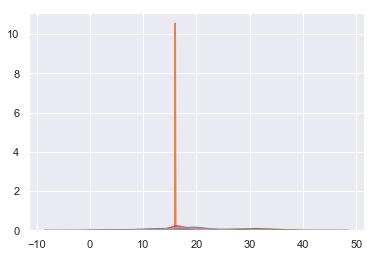

In [57]:
def mogp(traj, synch_gp, route_n, seg_n):

    def make_prediction(model, data):
        X = data[['lat', 'lon']].values.reshape(1, 2)
        return gp.predict(model, X)

    def corresponding_pred_model(lik_model):
        return gp.load(PREDICTION_MODEL, lik_model.route_n, lik_model.traj_n, lik_model.seg_n)

    def models_by_likelihood(synched_traj, models):
        def mk_model(m): 
            model = gp.build(synched_traj, ['tau'], ['lat', 'lon'], '', m.route_n, m.traj_n, m.seg_n)
            return gp.set_params(model, m.model.param_array)

        models_with_this_traj = [mk_model(m) for m in models]
        sorted_models = sorted(models_with_this_traj, key=gp.loglik, reverse=True)
        max_loglik = np.max([gp.loglik(m) for m in sorted_models])
        return [(m, np.exp(gp.loglik(m) - max_loglik)) for m in sorted_models]

    synched_traj = synch_data(synch_gp, traj)
    latest_data_point = synched_traj.iloc[-1]
    print(latest_data_point)
    models = gp.load_trajs(LIKELIHOOD_MODEL, route_n, seg_n)
    lik_models_with_weights = models_by_likelihood(synched_traj, models)
    pred_models_with_weights = [(corresponding_pred_model(m), w) for m, w in lik_models_with_weights]
    predictions_with_weights = [(make_prediction(m, latest_data_point), w) for m, w in pred_models_with_weights]
    weighted_predictions = [(float(p[0]), float(p[1])) for p, w in predictions_with_weights] 
    return weighted_predictions

test = pd.read_pickle('test.pkl')
n_test_trajs = test.traj.unique()
n_test_trajs = test.traj.unique()
n_test_segs = test.seg.unique()

def predict(traj, synch_gp, route_n, seg_n, plot=False):
    mixture = mogp(traj, synch_gp, route_n, seg_n)
    print(mixture[1])
    if plot:
        ax = sns.kdeplot(np.random.normal(mixture[0][0], mixture[0][1], size=50))
        for mean, sigma in mixture[1:]:
            x = np.random.normal(mean, sigma, size=50)
            sns.kdeplot(x, ax=ax)

    most_confident_model = sorted(mixture, key=lambda p: p[1])[0]
    prediction = most_confident_model[0]
    return prediction

np.random.seed(1)
test_traj = test[test.traj == n_test_trajs[0]]
seg_n = test_traj.seg.unique()[0]
test_seg = test_traj[test_traj.seg == seg_n]
i = np.random.randint(test_seg.index[0], test_seg.index[-1])
test_seg = test_seg[test_seg.index <= i]
print(test_seg)
synch_gp = gp.load_synch(route_n, seg_n)
pred = predict(seg, synch_gp, route_n, seg_n, plot=True)
true = test_seg.iloc[i].time_left
pred-true

# LÅT STÅ OS
#for traj_n in n_test_trajs:
#    traj = test[test.traj == traj_n]
#    n_traj_segs = traj.seg.unique()
#    for seg_n in n_traj_segs[0:1]:
#        seg = traj[traj.seg == seg_n]
#        i = np.random.randint(seg.index[0], seg.index[-1])
#       seg = seg[seg.index < i]
#        synch_gp = gp.load_synch(route_n, seg_n)
 #       predict(seg, synch_gp, route_n, seg_n)